In [1]:
import numpy as np
import xarray
import rioxarray as rio
import matplotlib.pyplot as plt
import cartopy as cp
import cartopy.feature as cfeature
import cmocean

In [2]:
# set filepath KNMI radar data
filename_h5 = r'RAD_NL25_PCP_NA_201910281900.h5'

In [3]:
# define geotransform / rastersize
gt = (0.0, 1000.0, 0.0, -3650000.0, 0.0, -1000.0)
xsize, ysize = (700, 765)

# upper left coord
xul = gt[0]
yul = gt[3]

# stepsize
xres = gt[1]
yres = gt[5]

# get the edge coordinates and add half the resolution 
# to go to center coordinates
xmin = xul + xres * 0.5
xmax = xul + (xres * xsize) - xres * 0.5
ymin = yul + (yres * ysize) + yres * 0.5
ymax = yul - yres * 0.5

# define x and y values
xs = np.mgrid[xmin:xmax+xres:xres]
ys = np.mgrid[ymax+yres:ymin:yres]

In [4]:
# define PROJ4 projection strings
proj4_rad = '+proj=stere +x_0=0 +y_0=0 +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378137 +b=6356752'
proj4_rd = '+proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs +<>'

In [5]:
# load the radara data and assign source projection
xds = xarray.open_dataset(filename_h5, group='/image1')
xds = xds.where(xds.image_data != 255) # nodata value
xds = xds.rename_dims({'phony_dim_0':'y', 'phony_dim_1':'x'})
xds = xds.assign_coords({'y':ys,'x' :xs})
xds = xds.rio.write_crs(rio.crs.CRS.from_proj4(proj4_rad))
xds['image_data'] = xds.image_data/100  # source is value * 100 [mm]

In [6]:
# uncomment to save as tif or to reproject to RD projection

# # Filename h5 converted to tif
# filename_rad = 'RAD_NL25_PCP_NA_201910281900_rad.tif'
# xds.rio.to_raster(filename_rad)

# # Reproject to RD projection
# # Filename tif reprojected to RD
# filename_rd = 'RAD_NL25_PCP_NA_201910281900_rd.tif'

# xds_rd = xds.rio.reproject(proj4_rd)
# xds_rd.rio.to_raster(filename_rd)

In [7]:
# define Cartopy projection defintions
# projection source data
globe = cp.crs.Globe(semimajor_axis=6378137, semiminor_axis=6356752)
crs_rad = cp.crs.Stereographic(central_latitude=90, central_longitude=0, false_easting=0, false_northing=0, true_scale_latitude=60, globe=globe)

# projection RD
crs_rd = cp.crs.Stereographic(central_longitude=5.3876388888, central_latitude=52.15616055555, false_easting=155000, false_northing=463000, scale_factor=0.9999079)

In [8]:
# set 0 values to NaN
xds = xds.where(xds.image_data != 0)

In [9]:
# collect country shapefile
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    facecolor='none')

In [10]:
# create a custom colorbar
mycmap = cmocean.tools.crop_by_percent(cmocean.cm.oxy, 50, which='min', N=None)

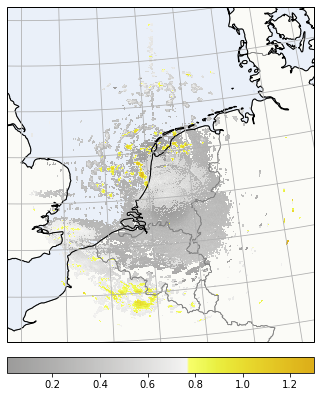

In [11]:
# make a figure in original projection as source data
plt.figure(figsize=(5.5, 7))
ax = plt.axes(projection=crs_rad)
ax.gridlines() # can only be in degrees, maybe with cartopy v0.18 more choice
ax.add_feature(cfeature.LAND.with_scale('10m'), alpha=0.2)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), alpha=0.2)
ax.add_feature(countries, edgecolor='gray', linewidth=0.75)
ax.coastlines(resolution='10m', color='k', linewidth=1)
im = ax.pcolormesh(xds.x.values, xds.y.values, xds.image_data.values, transform=crs_rad, cmap=mycmap)
cb = plt.colorbar(im, fraction=0.0476, pad=0.04, orientation='horizontal')
plt.show()